Loading datasets...
Engineering features...
Engineering features...
Preprocessing data...

Training model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 16
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will 

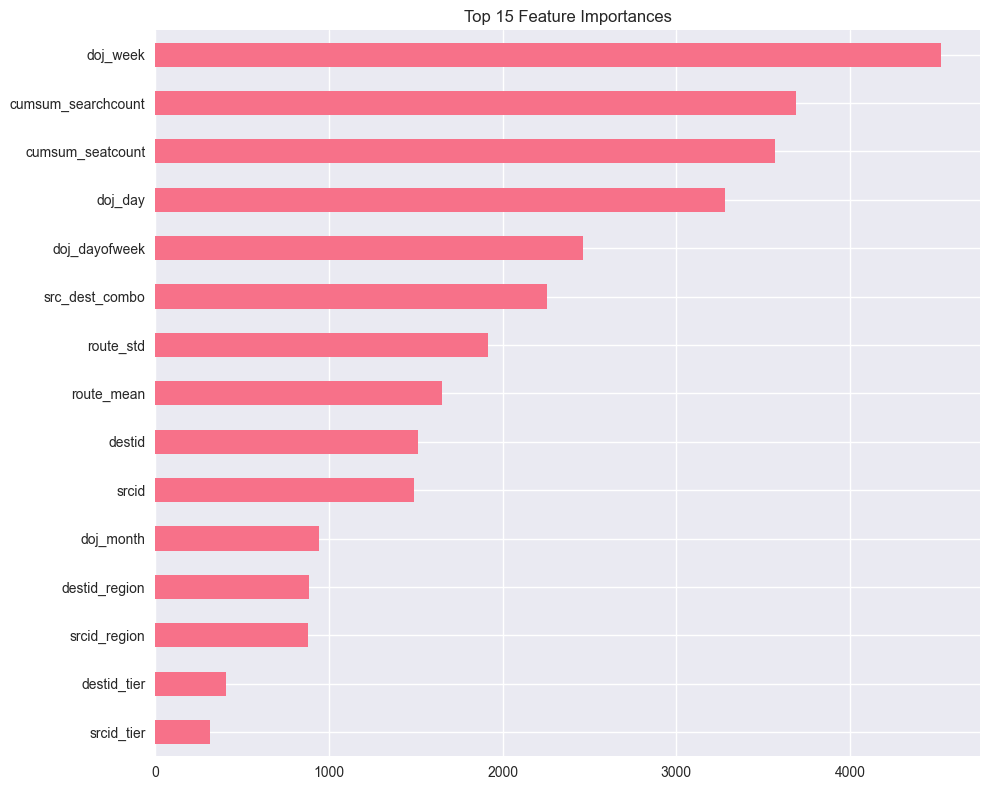

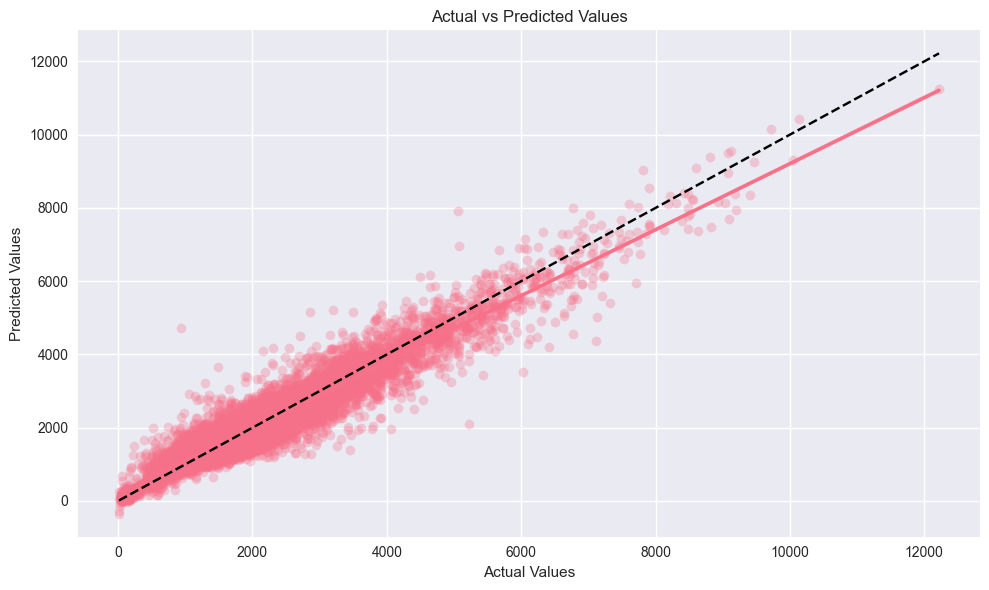

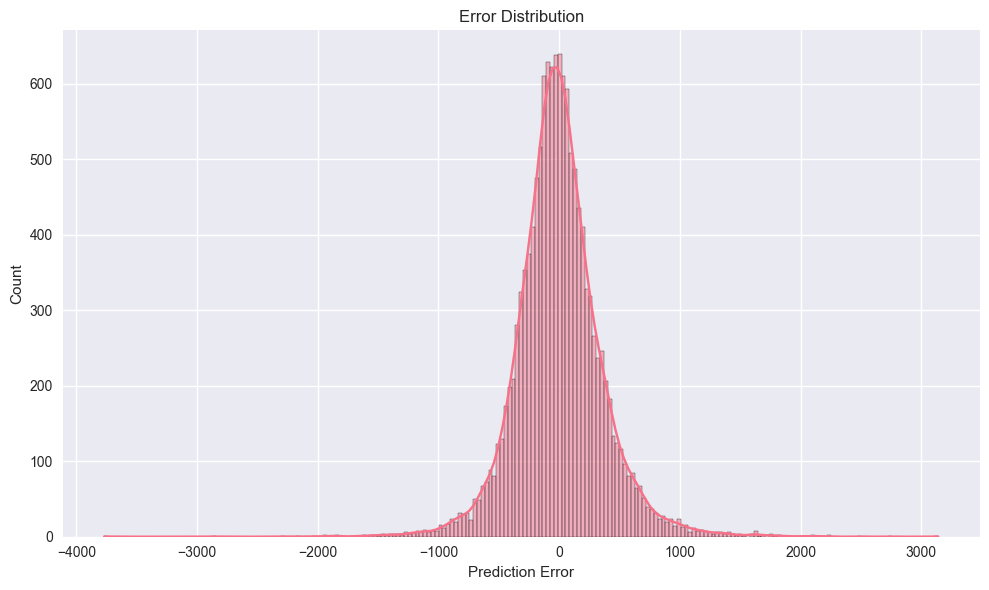


Preparing test data...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

Submission saved as 'submission4.csv'


In [ ]:
"""
Bus Seat Demand Forecasting Pipeline

A comprehensive machine learning pipeline for predicting bus seat demand using LightGBM.
This implementation includes feature engineering, model training, evaluation, and prediction.

Key Features:
- Temporal feature extraction
- Route-based statistical features
- LightGBM with early stopping
- Comprehensive evaluation metrics
- Visual diagnostics
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from scipy import stats

# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

# --- Constants ---
RANDOM_STATE = 42
TEST_SIZE = 0.2
EARLY_STOPPING_ROUNDS = 100
LOG_EVALUATION_PERIOD = 100

def load_data():
    """Load and merge datasets"""
    print("Loading datasets...")
    train = pd.read_csv("../data/train.csv")
    test = pd.read_csv("../data/test.csv")
    transactions = pd.read_csv("../data/transactions.csv")
    
    # Filter transactions to 15 days before departure
    transactions = transactions[transactions["dbd"] == 15]
    
    # Merge datasets
    train = train.merge(transactions, on=["doj", "srcid", "destid"], how="left")
    test = test.merge(transactions, on=["doj", "srcid", "destid"], how="left")
    
    return train, test

def engineer_features(df):
    """Create temporal and route-based features"""
    print("Engineering features...")
    
    # Convert to datetime
    df["doj"] = pd.to_datetime(df["doj"])
    df["doi"] = pd.to_datetime(df["doi"])
    
    # Temporal features
    df["days_until_travel"] = (df["doj"] - df["doi"]).dt.days
    df["doj_day"] = df["doj"].dt.day
    df["doj_week"] = df["doj"].dt.isocalendar().week.astype(int)
    df["doj_month"] = df["doj"].dt.month
    df["doj_dayofweek"] = df["doj"].dt.dayofweek
    df["is_weekend"] = df["doj_dayofweek"].isin([5, 6]).astype(int)
    
    # Route features
    df["src_dest_combo"] = df["srcid"].astype(str) + "_" + df["destid"].astype(str)
    
    return df

def preprocess_data(train, test):
    """Preprocess data for modeling"""
    print("Preprocessing data...")
    
    # Encode categorical features
    combo_map = {k: i for i, k in enumerate(train["src_dest_combo"].unique())}
    train["src_dest_combo"] = train["src_dest_combo"].map(combo_map)
    test["src_dest_combo"] = test["src_dest_combo"].map(combo_map).fillna(-1).astype(int)
    
    # Add route statistics
    route_stats = train.groupby(["srcid", "destid"])["final_seatcount"].agg(["mean", "std"]).reset_index()
    route_stats.columns = ["srcid", "destid", "route_mean", "route_std"]
    train = train.merge(route_stats, on=["srcid", "destid"], how="left")
    test = test.merge(route_stats, on=["srcid", "destid"], how="left")
    
    # Prepare features
    X = train.drop(columns=["final_seatcount", "doj", "doi"], errors="ignore")
    y = train["final_seatcount"]
    X_test = test.drop(columns=["doj", "doi"], errors="ignore")
    
    # Encode remaining categoricals
    encoders = {}
    for col in X.select_dtypes(include=["object"]).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        encoders[col] = le
        if col in X_test.columns:
            X_test[col] = le.transform(X_test[col].astype(str))
    
    return X, y, X_test, encoders

def train_model(X_train, y_train, X_val, y_val):
    """Train LightGBM model with early stopping"""
    print("\nTraining model...")
    
    model = LGBMRegressor(
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        n_estimators=1000,
        random_state=RANDOM_STATE,
        force_col_wise=True  # Suppress warning
    )
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[
            early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            log_evaluation(period=LOG_EVALUATION_PERIOD)
        ]
    )
    
    return model

def evaluate_model(model, X_val, y_val):
    """Evaluate model performance and generate diagnostics"""
    print("\nEvaluating model...")
    
    # Generate predictions
    val_preds = model.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    mae = mean_absolute_error(y_val, val_preds)
    r2 = r2_score(y_val, val_preds)
    
    print(f"\nValidation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    feat_imp = pd.Series(model.feature_importances_, index=X_val.columns)
    feat_imp.nlargest(15).sort_values().plot(kind='barh')
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_val, y=val_preds, scatter_kws={'alpha':0.3})
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    plt.show()
    
    # Plot error distribution
    errors = y_val - val_preds
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.title('Error Distribution')
    plt.tight_layout()
    plt.savefig('error_distribution.png')
    plt.show()

def prepare_test_data(X_test, X_train, encoders):
    """Prepare test data for prediction"""
    print("\nPreparing test data...")
    
    X_test = X_test.fillna(0)
    
    # Encode categoricals
    for col in X_test.select_dtypes(include=["object"]).columns:
        if col in encoders:
            le = encoders[col]
            X_test[col] = le.transform(X_test[col].astype(str))
        else:
            X_test[col] = LabelEncoder().fit_transform(X_test[col].astype(str))
    
    # Align columns
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]
    
    return X_test

def main():
    """Main execution pipeline"""
    # Load and prepare data
    train, test = load_data()
    train = engineer_features(train)
    test = engineer_features(test)
    
    # Preprocess
    X, y, X_test, encoders = preprocess_data(train, test)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    
    # Train model
    model = train_model(X_train, y_train, X_val, y_val)
    
    # Evaluate
    evaluate_model(model, X_val, y_val)
    
    # Prepare test data
    X_test_processed = prepare_test_data(X_test, X_train, encoders)
    
    # Generate predictions
    y_pred_test = model.predict(X_test_processed)
    test["final_seatcount"] = y_pred_test
    submission = test[["route_key", "final_seatcount"]]
    
    # Save results
    submission.to_csv("submission4.csv", index=False)
    print("\nSubmission saved as 'submission.csv'")
    
    #Save model artifacts using joblib
    artifacts = {
        'model': model,
        'encoders': encoders,
        'feature_columns': list(X_train.columns)
    }

    joblib.dump(artifacts, 'models/production_v1.pkl')

if __name__ == "__main__":
    main()
    
